# Lowlands analysis

Possible TODOs:
    -Weighting stories/utterances for valence per participant in chain
    -Checking how demographics matter for findings so far (e.g. gender/edu)
    -Checking how dependency distances change throughout chains

## Setup
Importing necessary modules and initialising the Frog parser

In [1]:
import os
import csv
import re
import spacy


import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


# assign wd
wd = os.getcwd()

## Preprocessing
We first remove additional codes from the transcripts and create a list of of theme ids. There are 5 themes:
-01, 11 and 21 indicate the 'koffiebekers' story, 
-02, 12 and 22 the 'rode pet' story, 
-03, 13 and 23 indicate the 'kipfilet' story, 
-04, 14 and 24 indicate the 'bank' story, 
-05, 15 and 25 the 'opgraving' story.

In [2]:
themes  = ['01', '11', '21'], ['02', '12', '22'], ['03', '13', '23'], ['04', '14', '24'], ['05', '15', '25']

In [3]:
def remove(raw):
    '''a function using regexp to remove coding and other noise in the transcript'''
    
    raw = re.sub(r'(X|x)x{2,}', '', raw)                        # removes unclear speech codes (Xxx-xxx)
    raw = re.sub(r'\w+\.?\*n','', raw)                          # removes self-made words, onomatopeias (*n)
    raw = re.sub(r'(\w+\.?\*a)', '', raw)                       # removes broken off words (*a)
    raw = re.sub(r'\.?\*v', '', raw)                            # removes notation for foreign words (*v)
    raw = re.sub(r'(\w+\-)+(\w+)\.?\*u', r'\2', raw)            # removes restarts of fully pronounced words (*u)
    #raw = re.sub(r"([A-Z]+(\w)*-?(\w)+('(\w)+)?)", '', raw)    # removes capitalized words, single letters
    raw = re.sub(r'[eE]hm', '', raw)                            # removes standard interjection
    raw = re.sub(r'\?{2,}', '', raw)                            # removes two or more ?? in text
    return raw

In [4]:
def extract_storystrings():
    '''this function makes a list of file names 
    of the transcripts to open, read and loop over,
    it returns a dict with story IDs as keys and stories as value'''
    
    stories = []
    
    for i in themes:
        story_ids = [f for f in os.listdir(f'{wd}/Lowlands_transcripts') if f[:2] in i]
        story_ids.sort()

        for s in story_ids:
            with open(f'{wd}/Lowlands_transcripts/{s}', mode='r', encoding='utf-8-sig') as f:
                stories.append([s[:4], remove(f.read())])
    
    return dict(stories)

In [5]:
stories_df = pd.DataFrame.from_dict(extract_storystrings(), orient='index', columns=['story'])
stories_df.reset_index(inplace=True)
stories_df.rename(columns={"index": "id"}, inplace=True)

## Creating a DataFrame

Here we create one pandas df object from various sources. First basic story stats are calculated such as types, tokens, and ratio, and step by step data from other sources is added to the df, such as POS-info from the Frog tagger and participant data from json files. Data is grouped by theme, chain and participant in the df. 

The full df is printed at the end of this section.   

In [20]:
def basics_dict(storydf):
    '''this function initialises a dictionary in which basic story properties are loaded as values,
    with story ID's as keys.'''
    
    stats = {}
    
    for key, text in dict(zip(storydf.id, storydf.story)).items():
        story = {}
        types = len(set([w for w in text.split() if w.isalpha()]))
        tokens =len([w for w in text.split() if w.isalpha()])
        story['theme'] = int(key[1])
        story['chain'] = int(key[0])
        story['participant'] = int(key[2:])
        story['tokens'] = tokens
        story['types'] = types
        story['ttr'] = round(types/tokens, 2)

        
        stats[key] = story
    return stats

In [23]:
stories_df.head()

,id,story
0,0100,vorig jaar werkten er op Lowlands twee vriendi...
1,0101,d'r waren twee meisjes.\nMirabella en Lotte e...
2,0102,er waren eens twee meisjes op Lowlands die sa...
3,0103,er waren twee meiden op Lowlands Lotta en Mira...
4,0104,oké d'r waren twee meisjes die werkten in een...


Here a series of steps to create the df from the dictionary returned by basics_dict(), reset the index and remove the 7th participant that was accidentally added in a chain.

In [28]:
propdict = basics_dict(stories_df)

storyprops_df = pd.DataFrame.from_dict(propdict, orient = 'index')
storyprops_df = storyprops_df.reset_index()
storyprops_df = storyprops_df.drop(storyprops_df[storyprops_df['participant'] > 6].index)
storyprops_df.rename(columns={"index": "id"}, inplace=True)

In [29]:
storyprops_df.head()

,id,theme,chain,participant,tokens,types,ttr
0,0100,1,0,0,392,194,0.49
1,0101,1,0,1,328,155,0.47
2,0102,1,0,2,451,171,0.38
3,0103,1,0,3,288,123,0.43
4,0104,1,0,4,273,122,0.45


In [32]:
df = pd.merge(storyprops_df, stories_df, how='left', on=['id'])
df.head()

,id,theme,chain,participant,tokens,types,ttr,story
0,0100,1,0,0,392,194,0.49,vorig jaar werkten er op Lowlands twee vriendi...
1,0101,1,0,1,328,155,0.47,d'r waren twee meisjes.\nMirabella en Lotte e...
2,0102,1,0,2,451,171,0.38,er waren eens twee meisjes op Lowlands die sa...
3,0103,1,0,3,288,123,0.43,er waren twee meiden op Lowlands Lotta en Mira...
4,0104,1,0,4,273,122,0.45,oké d'r waren twee meisjes die werkten in een...


We want to add information about the POS-tags in of each story retelling. We Frog the text line by line with pos() and save the output. pos_dists() extracts the POS-info from the output and the story IDs, condense() creates a dict of a dict, with in the outer dict IDs as key and in the inner dict POS-tags as keys and counts as values.


In [9]:
def pos(storydict):
    '''this function POS-tags (i.e. 'Frogs') a string line by line
    and saves output in a dict'''
    tags = []
    
    for i, s  in storydict.items():
        tags.append((i, frog.process(s)))
    
    return dict(tags)

In [10]:
def pos_dists(frog_output):
    '''this function extracts for each word in a story its tag
    and adds it to an empty list, with the first loop.'''
    
    pos = []
    ids = []
    
    for story in tags:
        ids.append(str(story))
        for i in range(len(tags[str(story)])):
            pos.append((story, tags[str(story)][i]['pos']))
        
            
    return pos, ids

In [11]:
def condense(parses, ids):
    '''this function creates and updates a dictionary with 
    number of POS-occurrences per story'''
    
    tagdict = []
    
    for i in ids:
        
        
        tag_dict = {"ADJ":0, "N":0, "WW":0, "VNW":0, "VZ":0, 
            "SPEC":0, "TW":0, "LID":0, "VG":0, "BW":0, "TSW":0, "LET":0}
        
        for word in parses:
            if word[0] == i:
            
                if "ADJ" in word[1]:
                    tag_dict["ADJ"] += 1
                elif "N(" in word[1]:
                    tag_dict["N"] += 1
                elif "WW" in word[1]:
                    tag_dict["WW"] += 1
                elif "VNW" in word[1]:
                    tag_dict["VNW"] += 1
                elif "VZ" in word[1]:
                    tag_dict["VZ"] += 1
                elif "SPEC" in word[1]:
                    tag_dict["SPEC"] += 1
                elif "TW" in word[1]:
                    tag_dict["TW"] += 1
                elif "LID" in word[1]:
                    tag_dict["LID"] += 1
                elif "VG" in word[1]:
                    tag_dict["VG"] += 1
                elif "BW" in word[1]:
                    tag_dict["BW"] += 1
                elif "TSW" in word[1]:
                    tag_dict["TSW"] += 1
                elif "LET" in word[1]:
                    tag_dict["LET"] += 1
        
        tagdict.append((i, tag_dict))
    
    return dict(tagdict)

Here the steps to create the df with POS-tags and merge it with the existing df 'storiesdict_df':

In [12]:
tags = pos(stories)
parses, ids = pos_dists(tags)
pos_dists = condense(parses, ids)
dist_df = pd.DataFrame.from_dict(pos_dists, orient='index')
dist_df = dist_df.reset_index()
storiesdict_df = storiesdict_df.merge(dist_df, left_on='index', right_on='index')

From the added POS-tags two general categories are made, content words (adjectives, verbs, nouns, adverbs, special) and function words (pronouns, interjections, articles, prepositions, numerals).

In [13]:
storiesdict_df['content_w'] = (storiesdict_df['ADJ'] + storiesdict_df['N'] +  storiesdict_df['WW'] + storiesdict_df['BW'] + storiesdict_df['SPEC']) / storiesdict_df['tokens']
storiesdict_df['function_w'] = (storiesdict_df['VNW'] + storiesdict_df['VZ'] +  storiesdict_df['TW'] + storiesdict_df['LID'] + storiesdict_df['TSW']) / storiesdict_df['tokens']

Finally, we also add participant statistics such as age, gender, education, from an external file:

In [14]:
raw_data = np.load(f'{wd}/data.npy', allow_pickle=True).item()

The following step creates from raw_data a dictionary sorted on the chain IDs, 
which in turn contains dictionaries with descriptives of each participant based on the index key:

In [15]:
descriptives_dict = {}

for key, value in raw_data.items():
    
    for index, data in value.items():
        pers_data = {}
        
        pers_data['gender'] = data['participantInput']['gender']
        pers_data['age'] = data['participantInput']['year']
        pers_data['educ'] = data['participantInput']['education']
    
        descriptives_dict[index] = pers_data
    
    
    

And the next steps merge the participant data to complete the df:

In [16]:
descriptives_df = pd.DataFrame.from_dict(descriptives_dict, orient='index')
descriptives_df = descriptives_df.reset_index()
storiesdict_df = storiesdict_df.merge(descriptives_df, how = 'left')

Here we give the full df. Some things are striking from the outset: a lot of missing values in the years variable, but not many missings for the gender and educ var:

In [17]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(storiesdict_df)

,index,theme,chain,participant,tokens,types,ttr,ADJ,N,WW,VNW,VZ,SPEC,TW,LID,VG,BW,TSW,LET,content_w,function_w,gender,age,educ
0,0100,1,0,0,392,194,0.49,21,82,85,61,51,36,17,39,24,25,1,44,0.635204,0.431122,female,1989.0,havo
1,0101,1,0,1,328,155,0.47,18,54,78,57,43,32,6,26,21,26,1,28,0.634146,0.405488,male,NaN,wo
2,0102,1,0,2,451,171,0.38,32,62,101,100,42,34,5,30,41,64,5,61,0.649667,0.403548,female,NaN,hbo
3,0103,1,0,3,288,123,0.43,13,36,65,52,33,25,3,22,28,36,0,25,0.607639,0.381944,female,1995.0,wo
4,0104,1,0,4,273,122,0.45,12,35,58,45,30,19,5,21,26,44,2,21,0.615385,0.377289,female,NaN,wo
5,0105,1,0,5,272,127,0.47,14,40,58,57,31,23,1,22,28,41,1,41,0.647059,0.411765,male,NaN,hbo
6,0106,1,0,6,291,118,0.41,20,37,70,78,35,21,1,20,28,25,4,48,0.594502,0.474227,NaN,NaN,NaN
7,1100,1,1,0,392,194,0.49,21,82,85,61,51,36,17,39,24,25,1,44,0.635204,0.431122,female,1989.0,havo
8,1101,1,1,1,427,179,0.42,28,63,87,80,51,33,6,41,43,53,5,63,0.618267,0.428571,female,NaN,wo
9,1102,1,1,2,460,160,0.35,27,77,95,89,53,31,4,51,37,63,8,70,0.636957,0.445652,female,NaN,wo


## Plots 

After plumbing as done above, now some more interesting things: plotting. We provide various plots and initial thoughts about what we are seeing in this section.

In the first plot of participant (x) against tokens and types (y), we see something that is a well-established given of stories in transmission: as the chains progress, the number of tokens and types greatly reduce. Tokens much more so than types, given their initial amounts in the seeds.

In [18]:
sns.set_style('whitegrid')

<AxesSubplot:xlabel='participant', ylabel='types'>

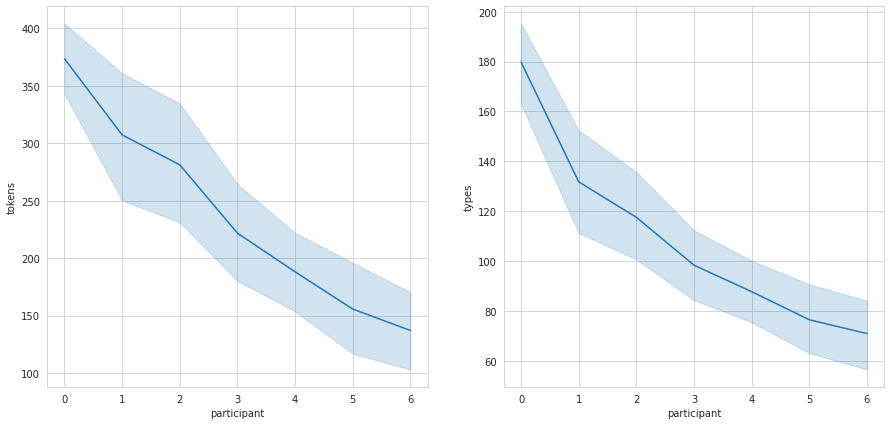

In [19]:
fig,axs = plt.subplots(figsize = (15, 7), ncols = 2, nrows = 1)
sns.lineplot(data = storiesdict_df, x = "participant", y = "tokens", ax = axs[0])
sns.lineplot(data = storiesdict_df, x = "participant", y = "types", ax = axs[1])

We group by theme (i.e. the different seed stories) to see if the progressions are different. The drop in tokens is quite dramatic for all themes. Both the story that starts with a large numbers of tokens in its seeds (\~450) and the story that starts with slightly more than half the number of that in its seed (~260) lose more than 50% of their tokens. For types this effect is about the same, although the progressions seem to be oscillating a bit less.

<AxesSubplot:xlabel='participant', ylabel='types'>

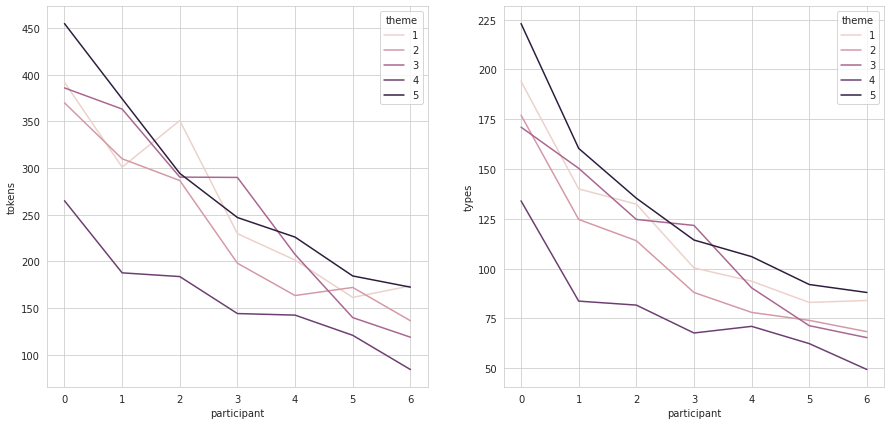

In [21]:
fig,axs = plt.subplots(figsize = (15, 7), ncols = 2, nrows = 1)
sns.lineplot(data = storiesdict_df, x = "participant", y = "tokens", hue = 'theme', ci = None, ax = axs[0])
sns.lineplot(data = storiesdict_df, x = "participant", y = "types", hue = 'theme', ci = None, ax = axs[1])

If we zoom in on theme 5, for example, we can see how each chain is doing. One exception that we is compressed in the general plot is that sometimes people add tokens in their retelling with respect to their seed. But the overall trend is one in which quite a bit of tokens/types get lost right away from the initial seed. This could be due to it being very dense in terms of content.

<AxesSubplot:xlabel='participant', ylabel='types'>

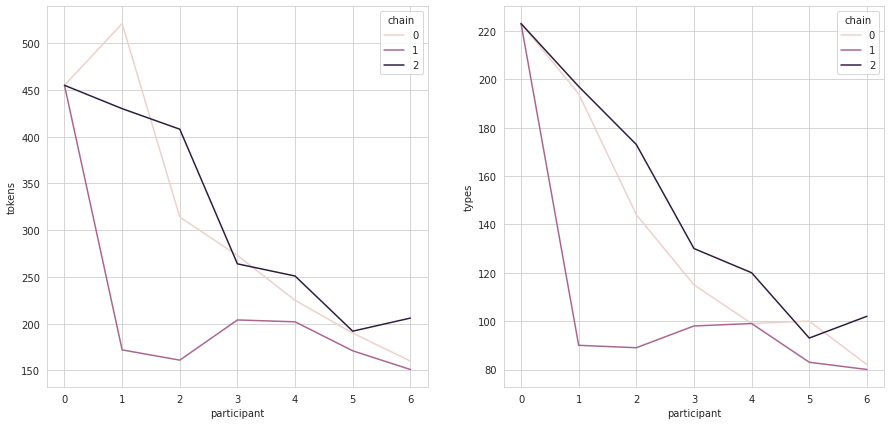

In [23]:
fig,axs = plt.subplots(figsize = (15, 7), ncols = 2, nrows = 1)
sns.lineplot(data = storiesdict_df[storiesdict_df['theme'] == 5], x = "participant", y = "tokens", hue = 'chain', ax = axs[0])
sns.lineplot(data = storiesdict_df[storiesdict_df['theme'] == 5], x = "participant", y = "types", hue = 'chain', ax = axs[1])

With the two more general POS-categories of content words and function words, we can see how all themes and chains do on average with respect to their proportions of content and function words. We see that there is actually a minimal difference in the proportions in their initial seeds: about 2,5% for content words and about 3,5% for function words. At the end of the chains there is more variance in proportions, for content words this is about 8% and for function words this is about 7%. 

Still these differences are very small. So the point to be made about this general graph is that the 5 different stories with respect to their content/function words division aren't that much different at all, although they cover quite different themes.

<AxesSubplot:xlabel='participant', ylabel='function_w'>

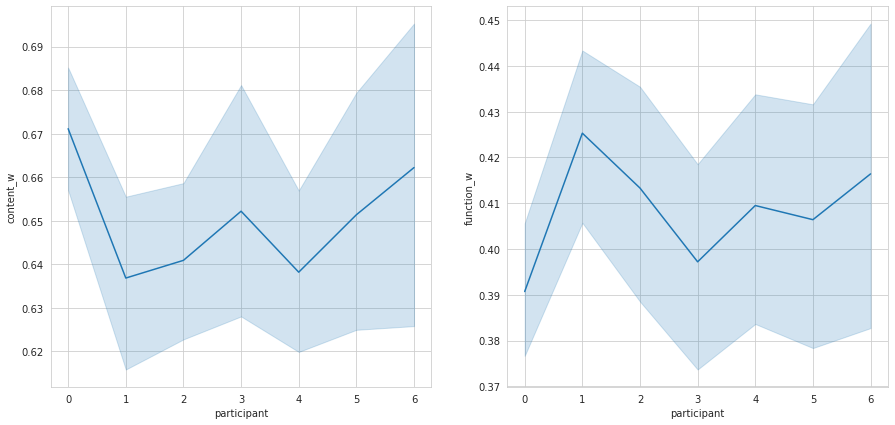

In [25]:
fig,axs = plt.subplots(figsize = (15, 7), ncols = 2, nrows = 1)
sns.lineplot(data = storiesdict_df, x = "participant", y = "content_w", ax = axs[0])
sns.lineplot(data = storiesdict_df, x = "participant", y = "function_w", ax = axs[1])

And here are both lines plotted in one graph. Here you can see more clearly that the differences between the two groups are rather small.

<AxesSubplot:xlabel='participant', ylabel='ratio'>

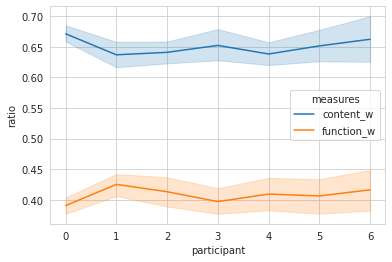

In [30]:
double_plot = pd.melt(storiesdict_df, id_vars = ['participant'], value_vars = ['content_w', 'function_w'], var_name = 'measures', value_name = 'ratio')
sns.lineplot(data = double_plot, x = "participant", y = "ratio", hue = 'measures')

We want to see how each theme is doing with respect to content words and function words in the story chain progression. Here we get a rather mixed view: some stories end with more content words compared to what they started with, some with less. We are still talking about marginal differences here. What is interesting again is that the steepest reduction seems to be after the initial seed, where there is most content available to be lost, whereas at step 3 more than half of the chains are adding more content.

With respect to the function words we see an opposite trend, after the initial seed people in almost all chains add a bit of function words, only to diminish the amount of function words a bit later again. The picture here is mixed and the differences within themes are small.

<AxesSubplot:xlabel='participant', ylabel='function_w'>

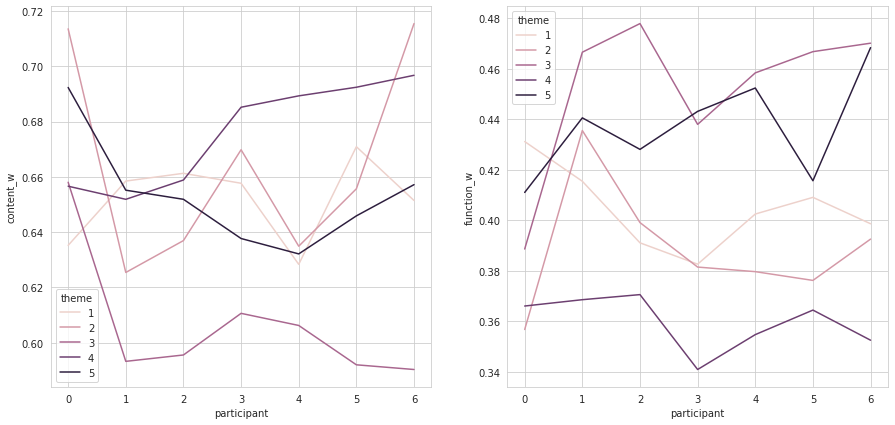

In [27]:
fig,axs = plt.subplots(figsize = (15, 7), ncols = 2, nrows = 1)
sns.lineplot(data = storiesdict_df, x = "participant", y = "content_w", hue = 'theme', ci = None, ax = axs[0])
sns.lineplot(data = storiesdict_df, x = "participant", y = "function_w", hue = 'theme', ci = None, ax = axs[1])